# Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm as progress 
from tensorflow.keras import Model
from tensorflow.data import Dataset 
from tensorflow.nn import relu, max_pool1d
from tensorflow.keras.optimizers import Adam
from pandas import read_csv, DataFrame, concat
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, Dense
from tensorflow import convert_to_tensor, squeeze, GradientTape, device, DeviceSpec, reshape
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Constant Variables
batch_size = 4096

# Loading SMS Data

In [2]:
df = read_csv("../../data/sms.csv")
df = df.drop(columns=["Unnamed: 0"])
df.sample(5)

,text,type
3745,"[10, 17, 2120, 5187, 5188, 17, 0, 0, 0, 0, 0, ...",0
933,"[194, 84, 10, 24, 347, 268, 1657, 1711, 0, 0, ...",0
4375,"[10, 15, 130, 36, 548, 127, 17, 9, 76, 2, 3, 3...",1
3592,"[409, 15, 10, 133, 443, 0, 0, 0, 0, 0, 0, 0, 0...",0
327,"[10, 79, 10, 454, 1003, 15, 363, 15, 268, 1282...",0


# Preparing SMS Data


In [3]:
# Load & Prepare Data
df["text"] = df["text"].apply(lambda sms: [int(word) for word in sms[1:-1].split(", ")])
df["type"] = df["type"].apply(lambda label: int(label))

# # Train / Valid / Test Split
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["type"], test_size=0.30, stratify=df["type"], random_state=2022)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.50, stratify=y_test, random_state=2022)

# Train / Test / Valid Dataset
train_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_train.to_list()), convert_to_tensor(y_train.to_list()))).batch(batch_size=batch_size)
valid_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_valid.to_list()), convert_to_tensor(y_valid.to_list()))).batch(batch_size=batch_size)
test_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_test.to_list()), convert_to_tensor(y_test.to_list()))).batch(batch_size=batch_size)


# Model

In [24]:
class SMSClassifier(Model):
    def __init__(self, path):
        super(SMSClassifier, self).__init__()
        self.path = path
        self.embedding = Embedding(6260, 8)
        self.dropout1 = Dropout(0.5)
        self.conv1 = Conv1D(8, kernel_size=2, strides=2, activation="relu")
        self.dropout2 = Dropout(0.5)
        self.conv2 = Conv1D(16, kernel_size=3, strides=3, activation="relu")
        self.dropout3 = Dropout(0.5)
        self.conv3 = Conv1D(32, kernel_size=4, strides=4, activation="relu")
        self.dropout4 = Dropout(0.5)
        self.fc1 = Dense(30, activation="relu")
        self.fc2 = Dense(15, activation="relu")
        self.fc3 = Dense(1, activation="sigmoid")

    def call(self, sentence):
        sentence = self.embedding(sentence)
        sentence = self.dropout1(sentence)
        sentence = self.conv1(sentence)
        sentence = self.dropout2(sentence)
        sentence = self.conv2(sentence)
        sentence = self.dropout3(sentence)
        sentence = self.conv3(sentence)
        sentence = max_pool1d(sentence, ksize=32, strides=18, padding="SAME")
        sentence = reshape(sentence, (sentence.shape[0], sentence.shape[2]))
        sentence = self.dropout4(sentence)
        sentence = self.fc1(sentence)
        sentence = self.fc2(sentence)
        sentence = self.fc3(sentence)
        return sentence

    def fit(self, datasets, epochs, optimizer, loss_fn, train_loss=[1], valid_loss=[1], best_epoch=0):
        with device(DeviceSpec(device_type="GPU")):
            for epoch in (tracker := progress(range(epochs))):
                tracker.set_description(f"Epoch #{epoch+1}")
                # Train Step
                train_loss.append(self.train_step(datasets[0], optimizer, loss_fn))
                # Eval Step
                valid_loss.append(self.eval_step(datasets[1], loss_fn))
                # Saving Model If Performance Improves
                if valid_loss[-1] <= min(valid_loss):
                    best_epoch = epoch
                    self.save(self.path)
                # Updating the tracker
                if epoch == epochs-1:
                    tracker.set_description(f"Best Epoch #{best_epoch+1}")
                    tracker.set_postfix_str(f"Training Loss = {train_loss[best_epoch]}, Validiation Loss = {valid_loss[best_epoch]}")
                else:
                    tracker.set_postfix_str(f"Training Loss = {train_loss[-1]}, Validiation Loss = {valid_loss[-1]}")
                    
        # Plotting Results
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4), dpi=250)
        ax.set_title("Training Loss (Green) vs Validation Loss (Blue)")
        ax.plot(train_loss, "g")
        ax.plot(valid_loss, "b")
        ax.set_xlim((0, len(train_loss)-1))
        ax.set_ylim((0, max(max(train_loss), max(valid_loss))))
        plt.show()
        
    def train_step(self, dataset, optimizer, loss_fn):
        for step, batch in enumerate(dataset):
            with GradientTape() as tape:
                y_pred = self(batch[0], training=True)
                loss = loss_fn(batch[1], y_pred)
            grads = tape.gradient(loss, self.trainable_weights)
            optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return loss.numpy()
    
    def eval_step(self, dataset, loss_fn):
        for step, batch in enumerate(dataset):
            y_pred = self(batch[0], training=False)
            loss = loss_fn(batch[1], y_pred)
        return loss.numpy()
    
    def evaluate(self, dataset, y_pred=[], y_true=[]):
        self.load(self.path)
        for step, batch in enumerate(dataset):
            y_pred.extend([int(prediction[0] > 0.4) for prediction in (self(batch[0], training=False).numpy())])
            y_true.extend(batch[1])
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        rc1, rc2, rc3 = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(rc2,  rc1)
        print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nPR_AUC: {pr_auc}")
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=[0, 1]).plot()
        plt.show()
        return accuracy, precision, recall, pr_auc
    
    def saveResults(self, lib, nam, typ, acc, pre, rec, pr):
        df = read_csv("../../data/results.csv")
        df2 = DataFrame([[lib, nam, typ, acc, pre, rec, pr]], 
                        columns=["Library", "Model", "Type", "Accuracy", "Precision", "Recall", "PR_AUC"])
        df = concat([df2, df])
        if "Unnamed: 0" in df:
            df = df.drop(columns=["Unnamed: 0"])
        df.to_csv("../../data/results.csv")

    def save(self, path):
        self.save_weights(path)

    def load(self, path, input_shape=(batch_size, 300)):
        self.build(input_shape)
        self.load_weights(path)

    def print(self, input_shape=(batch_size, 300)):
        self.build(input_shape)
        self.summary()

# Model Summary

In [25]:
model = SMSClassifier(path="../../models/cnn.h5")
model.print()

Model: "sms_classifier_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  50080     
_________________________________________________________________
dropout_20 (Dropout)         multiple                  0         
_________________________________________________________________
conv1d_15 (Conv1D)           multiple                  136       
_________________________________________________________________
dropout_21 (Dropout)         multiple                  0         
_________________________________________________________________
conv1d_16 (Conv1D)           multiple                  400       
_________________________________________________________________
dropout_22 (Dropout)         multiple                  0         
_________________________________________________________________
conv1d_17 (Conv1D)           multiple             

# Model Training

Best Epoch #122: 100%|██████████| 300/300 [00:59<00:00,  5.03it/s, Training Loss = 0.1901189386844635, Validiation Loss = 0.21968550980091095] 


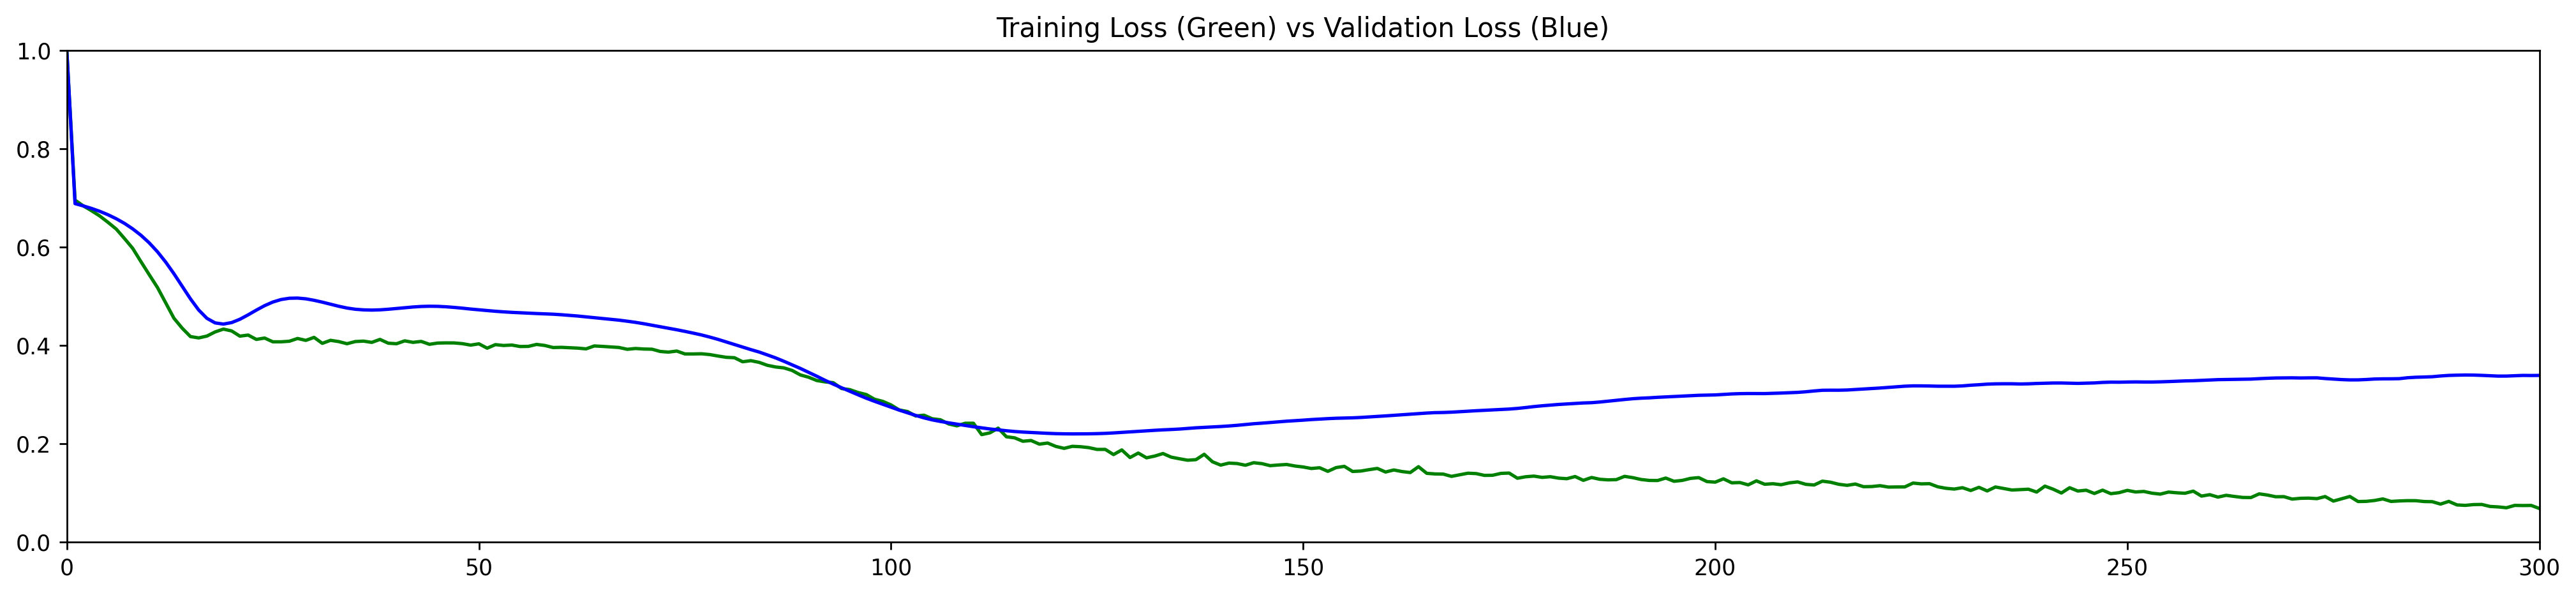

In [6]:
model.fit([train_dataset, valid_dataset], 300, Adam(learning_rate=1e-3), BinaryCrossentropy())

# Model Evaluation

Train Results
Accuracy: 0.9761538461538461
Precision: 0.919921875
Recall: 0.9005736137667304
PR_AUC: 0.9169144110500319


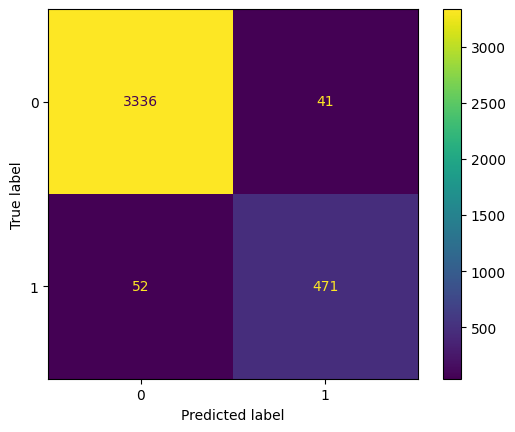

In [26]:
print("Train Results")
acc, pre, re, pr = model.evaluate(train_dataset)
model.saveResults("tensorflow", "cnn", "train", acc, pre, re, pr)

Valid Results
Accuracy: 0.9672719594594594
Precision: 0.8934426229508197
Recall: 0.8582677165354331
PR_AUC: 0.8853568589323155


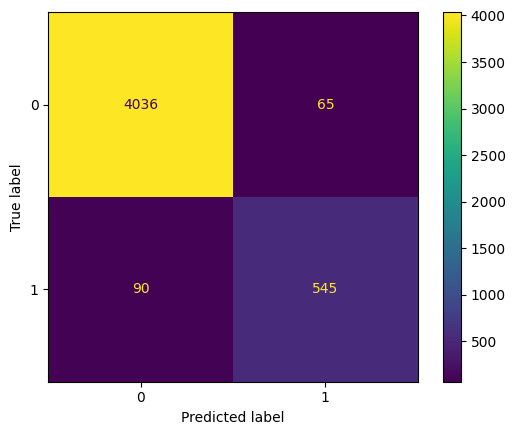

In [27]:
print("Valid Results")
acc, pre, re, pr = model.evaluate(valid_dataset)
model.saveResults("tensorflow", "cnn", "valid", acc, pre, re, pr)

Test Results
Accuracy: 0.9626704953338119
Precision: 0.8758716875871687
Recall: 0.8406961178045516
PR_AUC: 0.868962294655659


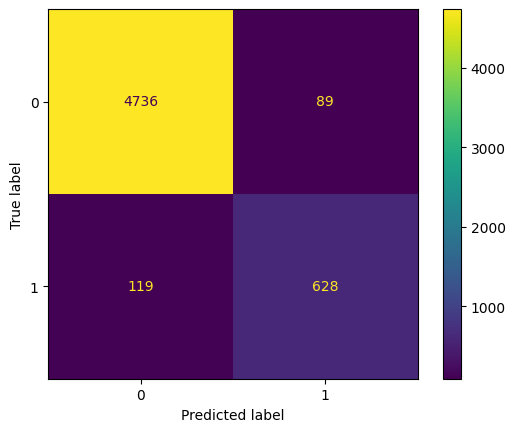

In [28]:
print("Test Results")
acc, pre, re, pr = model.evaluate(test_dataset)
model.saveResults("tensorflow", "cnn", "test", acc, pre, re, pr)